In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv('gurgaon_properties_post_feature_selection_v2.csv')

In [4]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,0.0,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,0.0,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,0.0,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,1.0,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,0.0,High,Mid Floor


In [5]:
df['furnishing_type'].value_counts()

furnishing_type
0.0    2349
1.0    1018
2.0     187
Name: count, dtype: int64

In [6]:
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished', 1.0:'semifurnished', 2.0:'furnished'})
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,unfurnished,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,unfurnished,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,unfurnished,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,semifurnished,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,unfurnished,High,Mid Floor


In [7]:
X = df.drop(columns=['price'])
y = df['price']

In [8]:
y_transformed = np.log1p(y)

### Ordinal Encoding

In [9]:
columns_to_encode = ['property_type', 'sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

In [10]:
# Creating a column transformer for preprocessing

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode)
    ],
    remainder = 'passthrough'
)

In [11]:
# Creating a Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [12]:
# K-fold cross-validation
kfold = KFold(n_splits = 10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [13]:
scores.mean(), scores.std()

(np.float64(0.7363096633436828), np.float64(0.03238005754429936))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

In [15]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category'])])),
                ('regressor', LinearRegression())])

In [16]:
y_pred = pipeline.predict(X_test)
y_pred = np.expm1(y_pred)

In [17]:
mean_absolute_error(np.expm1(y_test), y_pred)

np.float64(0.9463822160089356)

In [18]:
def scorer(model_name, model):
    output = []
    output.append(model_name)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test), y_pred))
    
    return output

In [19]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

In [20]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree':DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees':ExtraTreesRegressor(),
    'gradient boosting':GradientBoostingRegressor(),
    'adaboost':AdaBoostRegressor(),
    'mlp':MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [21]:
model_output = []
for model_name, model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [22]:
model_output

[['linear_reg',
  np.float64(0.7363096633436828),
  np.float64(0.9463822160089356)],
 ['svr', np.float64(0.7642012011196353), np.float64(0.8472636473483922)],
 ['ridge', np.float64(0.7363125343993554), np.float64(0.9463387741853386)],
 ['LASSO', np.float64(0.05943378064493573), np.float64(1.528905986892753)],
 ['decision tree',
  np.float64(0.7719058041639171),
  np.float64(0.7354889274009931)],
 ['random forest',
  np.float64(0.8817388336385404),
  np.float64(0.5288010170577171)],
 ['extra trees',
  np.float64(0.8671209526566812),
  np.float64(0.5481145900703084)],
 ['gradient boosting',
  np.float64(0.8726202933639229),
  np.float64(0.5755118172341468)],
 ['adaboost', np.float64(0.7569581280841142), np.float64(0.7974966407690665)],
 ['mlp', np.float64(0.8045017691079538), np.float64(0.6825284006820286)],
 ['xgboost', np.float64(0.8894876835260124), np.float64(0.5040475141482346)]]

In [23]:
model_df = pd.DataFrame(model_output, columns=['name', 'r2', 'mae']).sort_values(by='mae')

In [24]:
model_df

,name,r2,mae
10,xgboost,0.889488,0.504048
5,random forest,0.881739,0.528801
6,extra trees,0.867121,0.548115
7,gradient boosting,0.872620,0.575512
9,mlp,0.804502,0.682528
4,decision tree,0.771906,0.735489
8,adaboost,0.756958,0.797497
1,svr,0.764201,0.847264
2,ridge,0.736313,0.946339
0,linear_reg,0.736310,0.946382


### OneHotEncoding

In [25]:
# Creating a column transformer for preprocessing

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1', OneHotEncoder(drop='first'), ['sector', 'agePossession', 'furnishing_type'])
    ],
    remainder = 'passthrough'
)

In [26]:
# Creating a Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [27]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [28]:
scores.mean()

np.float64(0.8546094810971422)

In [29]:
scores.std()

np.float64(0.015997422908695623)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'sector',
                                                   'balcony', 'agePossession',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('cat1',
                                                  OneHotEncoder(drop='first'),
                                                  ['sector', 'agePossession',
                                                   'furnishing_type'])])),
                ('regressor', LinearRegression())])

In [32]:
y_pred = pipeline.predict(X_test)

In [33]:
y_pred = np.expm1(y_pred)

In [34]:
mean_absolute_error(np.expm1(y_test), y_pred)

np.float64(0.6497514315131458)

In [35]:
def scorer(model_name, model):
    output = []
    output.append(model_name)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test), y_pred))
    
    return output

In [36]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree':DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees':ExtraTreesRegressor(),
    'gradient boosting':GradientBoostingRegressor(),
    'adaboost':AdaBoostRegressor(),
    'mlp':MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [37]:
model_output = []
for model_name, model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [38]:
model_df = pd.DataFrame(model_output, columns=['name', 'r2', 'mae'])

In [39]:
model_df.sort_values(['mae'])

,name,r2,mae
6,extra trees,0.894169,0.468941
10,xgboost,0.895850,0.493456
5,random forest,0.891346,0.500686
9,mlp,0.872451,0.555899
7,gradient boosting,0.876521,0.568676
0,linear_reg,0.854609,0.649751
2,ridge,0.854739,0.652915
4,decision tree,0.804330,0.686244
8,adaboost,0.757360,0.822223
1,svr,0.769741,0.834124


### OneHotEncoding with PCA

In [40]:
# Creating a column transformer for preprocessing

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1', OneHotEncoder(drop='first', sparse_output=False), ['sector', 'agePossession'])
    ],
    remainder = 'passthrough'
)

In [41]:
# Creating a Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),
    ('regressor', LinearRegression())
])

In [42]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')

In [43]:
scores.mean()

np.float64(0.06225201431451135)

In [44]:
scores.std()

np.float64(0.01986059407164016)

### Target Encoding
- used for those column which have high cardinality
- each sector -> value mean
- avoid Data Leakage <> do split beforhand

In [45]:
import category_encoders as ce

columns_to_encode = ['property_type', 'sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(), columns_to_encode),
        ('cat1', OneHotEncoder(drop='first', sparse_output=False), ['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)

In [46]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [47]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')


In [48]:
scores.mean(), scores.std()

(np.float64(0.8295219182255362), np.float64(0.018384463379122782))

In [49]:
def scorer(model_name, model):
    output = []
    output.append(model_name)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
    
    output.append(scores.mean())
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    y_pred = np.expm1(y_pred)
    
    output.append(mean_absolute_error(np.expm1(y_test), y_pred))
    
    return output

In [50]:
model_dict = {
    'linear_reg':LinearRegression(),
    'svr':SVR(),
    'ridge':Ridge(),
    'LASSO':Lasso(),
    'decision tree':DecisionTreeRegressor(),
    'random forest':RandomForestRegressor(),
    'extra trees':ExtraTreesRegressor(),
    'gradient boosting':GradientBoostingRegressor(),
    'adaboost':AdaBoostRegressor(),
    'mlp':MLPRegressor(),
    'xgboost':XGBRegressor()
}

In [51]:
model_output = []
for model_name, model in model_dict.items():
    model_output.append(scorer(model_name, model))

In [52]:
model_df = pd.DataFrame(model_output, columns=['name', 'r2', 'mae'])

In [53]:
model_df.sort_values(['mae'])

,name,r2,mae
10,xgboost,0.904798,0.447518
5,random forest,0.900565,0.454086
6,extra trees,0.901585,0.460579
7,gradient boosting,0.889018,0.509248
4,decision tree,0.828678,0.553169
9,mlp,0.855568,0.621653
8,adaboost,0.813363,0.672868
0,linear_reg,0.829522,0.713011
2,ridge,0.829536,0.713523
1,svr,0.782917,0.818851


### Hyperparameter Tuning of Random Forest

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10 , 20, 30],
    'regressor__max_samples': [0.1, 0.25, 0.5, 1.0],
    'regressor__max_features': ['auto', 'sqrt']
}

In [56]:
columns_to_encode = ['property_type', 'sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),  # Numerical features
        ('cat', OrdinalEncoder(), ['property_type', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']),  # Ordinal encoding for selected categorical features
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), ['agePossession']),  # One-hot encoding for 'agePossession'
        ('target_enc', ce.TargetEncoder(), ['sector'])  # Target encoding for 'sector'
    ],
    remainder='passthrough'  # Keep any other columns unchanged
)


In [57]:
# Creating a pipeline
pipeline = Pipeline( steps= [
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

In [58]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)


In [59]:
search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, scoring='r2', n_jobs=-1, verbose=4)

In [60]:
search.fit(X, y_transformed)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


c:\Users\DIVYANSHU\anaconda3\envs\dsmp\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
640 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
474 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DIVYANSHU\anaconda3\envs\dsmp\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DIVYANSHU\anaconda3\envs\dsmp\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\DIVYANSHU\anaconda3\envs\dsmp\Lib\site-packages\sklearn\

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['bedRoom',
                                                                          'bathroom',
                                                                          'built_up_area',
                                                                          'servant '
                                                                          'room',
                                                                          'store '
                                                                          'room']),
                                                                        ('cat',
                                                                         OrdinalEncoder(),
                                                                         ['property_type',
                                                                          'balcony',
                                                                          'furnishing_type',
                                                                          'luxury_category',
                                                                          'floor_...
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['agePossession']),
                                                                        ('target_enc',
                                                                         TargetEncoder(),
                                                                         ['sector'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['auto', 'sqrt'],
                         'regressor__max_samples': [0.1, 0.25, 0.5, 1.0],
                         'regressor__n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=4)

In [61]:
search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'balcony',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePossession']),
                                                 ('target_enc', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor',
                 RandomForestRegressor(max_features='sqrt', max_samples=1.0,
                                       n_estimators=200))])

In [62]:
search.best_params_

{'regressor__max_depth': None,
 'regressor__max_features': 'sqrt',
 'regressor__max_samples': 1.0,
 'regressor__n_estimators': 200}

In [63]:
search.best_score_

np.float64(0.8903720935787149)

### XGBoost Hyperparameter Tuning 

In [64]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_grid = {
    'regressor__max_depth': stats.randint(3, 10),
    'regressor__learning_rate': stats.uniform(0.01, 0.5),
    'regressor__subsample': stats.uniform(0.5, 0.5),
    'regressor__n_estimators':stats.randint(50, 200)
}



In [65]:
columns_to_encode = ['property_type', 'sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),  # Numerical features
        ('cat', OrdinalEncoder(), ['property_type', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']),  # Ordinal encoding for selected categorical features
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), ['agePossession']),  # One-hot encoding for 'agePossession'
        ('target_enc', ce.TargetEncoder(), ['sector'])  # Target encoding for 'sector'
    ],
    remainder='passthrough'  # Keep any other columns unchanged
)


In [66]:
# Creating a pipeline
pipeline = Pipeline( steps= [
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

In [67]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [68]:
# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_grid, n_iter=10, cv=kfold, scoring='r2', n_jobs=-1)

In [69]:
random_search.fit(X, y_transformed)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['bedRoom',
                                                                                'bathroom',
                                                                                'built_up_area',
                                                                                'servant '
                                                                                'room',
                                                                                'store '
                                                                                'room']),
                                                                              ('cat',
                                                                               OrdinalEncoder(),
                                                                               ['property_type',
                                                                                'balcony',
                                                                                'furnishing_type',
                                                                                'luxury_category',
                                                                                '...
                   param_distributions={'regressor__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002981C39BCB0>,
                                        'regressor__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002981A1C7E60>,
                                        'regressor__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002982F2CE840>,
                                        'regressor__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002982F169DC0>},
                   scoring='r2')

In [70]:
random_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['bedRoom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat', OrdinalEncoder(),
                                                  ['property_type', 'balcony',
                                                   'furnishing_type',
                                                   'luxury_category',
                                                   'floor_category']),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['agePos...
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=np.float64(0.15682147151266218),
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=135, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [71]:
random_search.best_params_

{'regressor__learning_rate': np.float64(0.15682147151266218),
 'regressor__max_depth': 8,
 'regressor__n_estimators': 135,
 'regressor__subsample': np.float64(0.8311315150997505)}

In [72]:
random_search.best_score_

np.float64(0.8997447814477146)

### Optimizing XGBoost with Hyperopt

In [95]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [96]:
columns_to_encode = ['property_type', 'sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),  # Numerical features
        ('cat', OrdinalEncoder(), ['property_type', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']),  # Ordinal encoding for selected categorical features
        ('onehot', OneHotEncoder(drop='first', sparse_output=False), ['agePossession']),  # One-hot encoding for 'agePossession'
        ('target_enc', ce.TargetEncoder(), ['sector'])  # Target encoding for 'sector'
    ],
    remainder='passthrough'  # Keep any other columns unchanged
)


In [97]:
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),  # Number of trees, expanded range
    'max_depth': hp.quniform('max_depth', 3, 15, 1),  # Increased range for tree depth
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # Exponentially distributed, values from ~0.001 to 1
    'subsample': hp.uniform('subsample', 0.6, 1),  # Limit subsample range to avoid underfitting
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),  # Range for using a subset of features
    'gamma': hp.loguniform('gamma', -3, 2),  # Exponentially distributed to cover small values to larger ones
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),  # Minimum weight, integer values
    'reg_alpha': hp.loguniform('reg_alpha', -5, 2),  # L1 regularization, very small to moderate values
    'reg_lambda': hp.loguniform('reg_lambda', -5, 2)  # L2 regularization, small to moderate values
}


In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

In [99]:
def objective(space):
  regressor = XGBRegressor(
    n_estimators = int(space['n_estimators']),
    max_depth = int(space['max_depth']),
    learning_rate = space['learning_rate'],
    subsample = space['subsample'],
    colsample_bytree = space['colsample_bytree'],
    gamma = space['gamma'],
    min_child_weight=space['min_child_weight'],
    reg_alpha=space['reg_alpha'],
    reg_lambda=space['reg_lambda'],
    random_state=42
  )
  pipeline = Pipeline( steps= [
    ('preprocessor', preprocessor),
    ('regressor', regressor)
  ])
  kfold = KFold(n_splits=10, shuffle=True, random_state=42)
  
  scores = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
  
  mae_loss = -scores.mean()

  return {'loss': mae_loss, 'status': STATUS_OK}

In [100]:
trials = Trials()
best = fmin(
  fn = objective,
  space = space,
  algo = tpe.suggest,
  max_evals = 200,
  trials = trials
)
print("Best Hyperparameter:", best)

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 200/200 [10:26<00:00,  3.13s/trial, best loss: 0.12304123006060048]
Best Hyperparameter: {'colsample_bytree': np.float64(0.9991967821382737), 'gamma': np.float64(0.05031272073360332), 'learning_rate': np.float64(0.10510112097423385), 'max_depth': np.float64(6.0), 'min_child_weight': np.float64(1.0), 'n_estimators': np.float64(850.0), 'reg_alpha': np.float64(0.0603083781923354), 'reg_lambda': np.float64(1.377750917464374), 'subsample': np.float64(0.6999662213515132)}


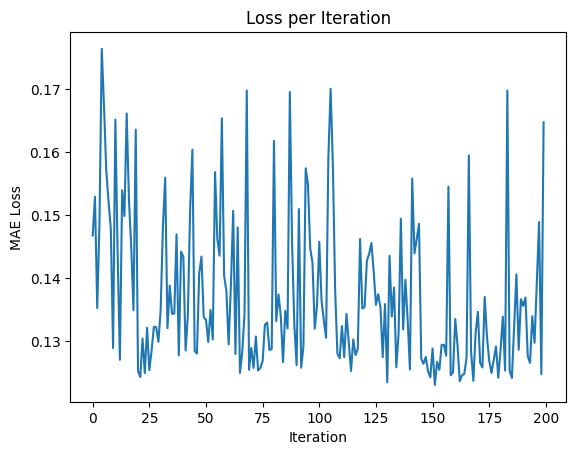

In [101]:
import matplotlib.pyplot as plt

# Extract trial results
results = [trial['result']['loss'] for trial in trials.trials]
plt.plot(results)
plt.xlabel('Iteration')
plt.ylabel('MAE Loss')
plt.title('Loss per Iteration')
plt.show()
